In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
from pymatreader import read_mat
import IPython
from pathlib import Path
from utilities import savefig, FKFit, perform_fit_rounds, FitInput, FitResult
from iminuit import Minuit
from iminuit.cost import LeastSquares, BinnedNLL
from scipy.special import softmax, erf
from scipy.stats import chi2
from scipy.optimize import curve_fit
import inspect
from dataclasses import dataclass
from typing import Callable

In [4]:
NB_NAME = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem

In [5]:
DATAPATH = os.path.join(os.path.abspath(""), "data", NB_NAME)

fnames = os.listdir(DATAPATH)
fnames = [os.path.join(DATAPATH, fname) for fname in fnames]

resistances = []
powers = []
counts = []
currents = []

for fname in fnames:
    data = read_mat(fname)["Data"]
    if fname.split("/")[-1] == "Power_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250113-130629_CTL_CW_321p5THz_-4V0p020uW_100p000uW.mat":
        data["Resistance"] = 3_000_000
    resistances.append(data["Resistance"])
    counts.append(data["MeasureCounts"])
    powers.append(1e6 * data["PowerMeasured"])
    currents.append(1e6 * data["MeasureCurrent"])

resistances = np.array(resistances)
res_sort_idc = np.argsort(resistances)

resistances = np.array(resistances)[res_sort_idc]
powers = np.array(powers)[res_sort_idc]
counts = np.array(counts)[res_sort_idc]
currents = np.array(currents)[res_sort_idc]

resistances = np.delete(resistances, 10)
powers = np.delete(powers, 10, axis=0)
counts = np.delete(counts, 10, axis=0)
currents = np.delete(currents, 10, axis=0)

powerlist = data["PowerList"] * 1e6


/home/ali/miniconda3/envs/university/lib/python3.11/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


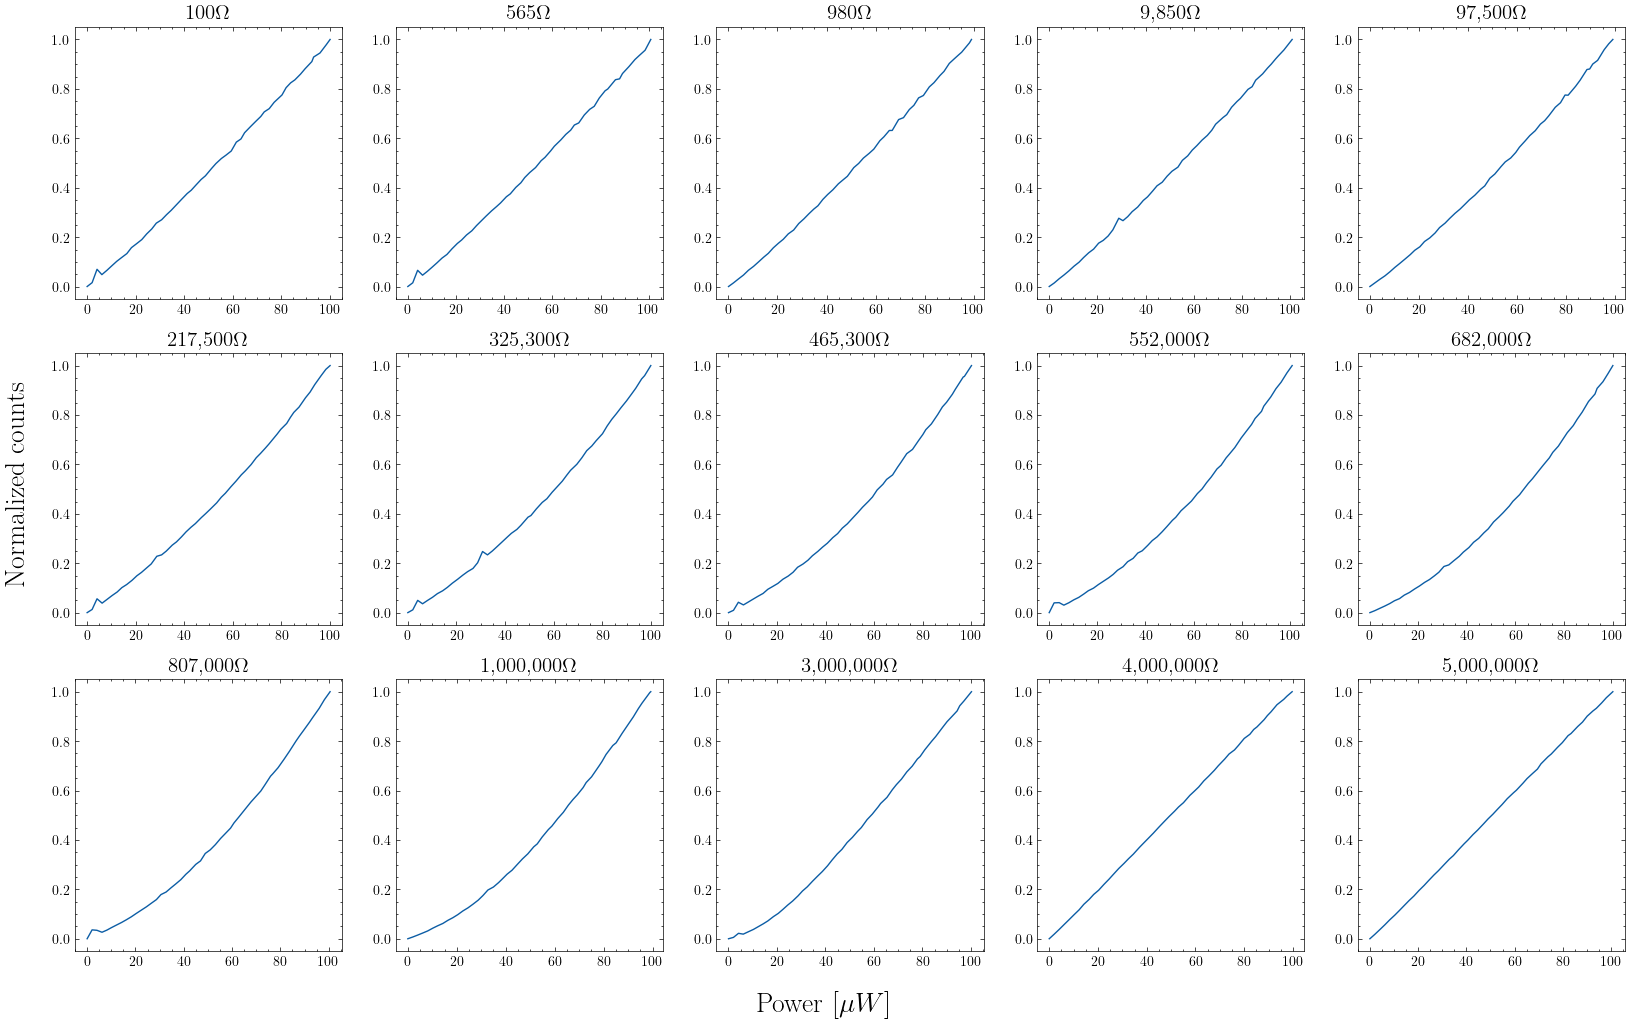

In [16]:
fig, axs = plt.subplots(3, 5, figsize=(20,12))
for i in range(len(resistances)):
    axs.ravel()[i].set_title(fr"{int(resistances[i]):,}$\Omega$", fontsize=15)
    axs.ravel()[i].plot(powers[i], counts[i] / np.max(counts[i]))
fig.text(0.5, 0.06, r'Power [$\mu W$]', ha='center', fontsize=20)
fig.text(0.09, 0.5, 'Normalized counts', va='center', rotation='vertical', fontsize=20)
# savefig(NB_NAME, "P_I_all_R", fig)
plt.show()

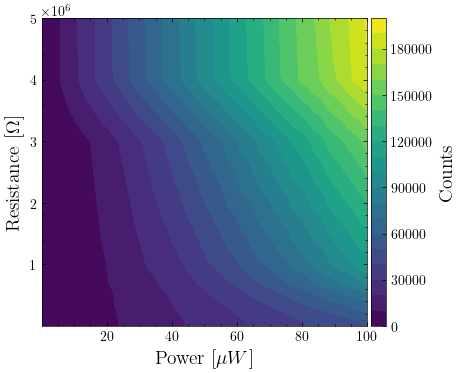

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
pcm = ax.contourf(np.linspace(0.02, 100, 50), resistances, counts, levels=20)
cb = fig.colorbar(pcm, ax=ax, pad = 0.01)
cb.set_label(r"Counts", fontsize=14)
ax.set_xlabel(r"Power [$\mu W$]", fontsize=14)
ax.set_ylabel(r"Resistance [$\Omega$]", fontsize=14)
# savefig(NB_NAME, "IPR_2d", fig)
plt.show()

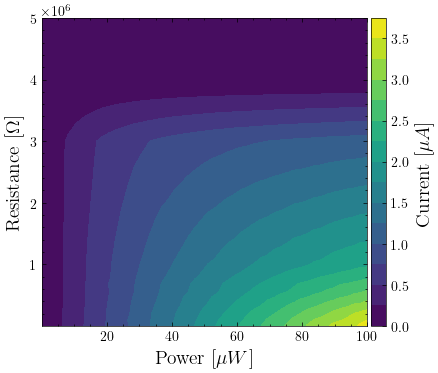

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
pcm = ax.contourf(np.linspace(0.02, 100, 50), resistances, np.abs(currents), levels=15)
cb = fig.colorbar(pcm, ax=ax, pad = 0.01)
cb.set_label(r"Current [$\mu A$]", fontsize=14)
ax.set_xlabel(r"Power [$\mu W$]", fontsize=14)
ax.set_ylabel(r"Resistance [$\Omega$]", fontsize=14)
# savefig(NB_NAME, "CPR_2D", fig)
plt.show()

In [6]:
outliers = [2, 2, [], 14, [39, 43], [2, 14], [2, 15], 2, [1, 2], [15], [1, 2], [], [2], [], []]

In [7]:
def softmax_fit(powers, a, b, c):
    return a * softmax(b * powers) + c

def softplus_fit(powers, a, b, c):
    return np.logaddexp(0, a * (powers -  b)) + c

def sigmoid_fit(powers, a, b, c):
    return a / (1 + np.exp(- b * (powers - c)))

def softplus2_fit(powers, a, b, c, d):
    return np.logaddexp(0, a * (powers +  b)) + np.logaddexp(0, c * (powers -  b)) + d

def lsoftplus_fit1(powers, a, b, c, d):
    return a * powers + (1 - a) * np.logaddexp(0, b * (powers - c)) + d

def lsoftplus_fit2(powers, a, b, c, d, e):
    return a * powers + d * np.logaddexp(0, b * (powers - c)) + e

def smu_fit1(powers, a, b, c, d):
    return c * ((1 + a) * powers + (1 - a) * powers * erf(b * (1 - a) * (powers - d)))

def sau_fit1(powers, a, b, c, d):
    return c * ((1 + a) * powers + (1 - a) * powers * erf(b * (1 - a) * (powers - d)))

def exp_fit(powers, nu, alpha, c):
    return nu * powers * np.exp(-alpha * 35e-4) + c # alpha in 1/cm

In [8]:
@classmethod
def build_fitinputs(
    cls,
    powers: np.ndarray,
    counts: np.ndarray,
    errors: np.ndarray,
    fit_func: Callable,
    initial_guesses: list[float],
):
    fit_inputs = []
    for i in range(len(powers)):
        if i == 0:
            fit_inputs.append(
                cls(powers[i], counts[i], errors[i], fit_func, initial_guesses)
            )
        else:
            fit_inputs.append(cls(powers[i], counts[i], errors[i], fit_func, []))
    return fit_inputs


@classmethod
def build_from_fk_fit(
    cls,
    powers: np.ndarray,
    counts: np.ndarray,
    errors: np.ndarray,
    initial_guesses: list[float],
    resistances: float,
    L: float,
    lam: float,
    x: float,
    T: float,
    V_app: float,
):
    fit_inputs = []
    for i in range(len(powers)):
        fk_fit = FKFit(powers[i], resistances[i], L, lam, x, T, V_app)
        fit_inputs.append(
            cls(
                powers[i],
                counts[i],
                errors[i],
                fk_fit.FK_fit_power_scaled,
                initial_guesses,
            )
        )
    return fit_inputs


FitInput.build_fitinputs = build_fitinputs
FitInput.build_from_fk_fit = build_from_fk_fit

def all_activation_fits(
    fit_inputs: list[FitInput],
    outliers: list[int | list[int]] | None = None,
    opt_rounds=10,
    softloss=False,
):
    fit_results = []

    for idx in range(len(fit_inputs)):
        fit_result = perform_fit_rounds(
            fit_inputs[idx],
            outlier=outliers[idx],
            opt_rounds=opt_rounds,
            softloss=softloss,
        )

        if not fit_result.success:
            print(f"NOTE: fit {idx} was not completely successful")

        fit_results.append(fit_result)

        if (idx < len(fit_inputs) - 1) and (opt_rounds > 0):
            fit_inputs[idx + 1].initial_guesses = fit_result.parameters
    return fit_results


def plot_all_activation_fits(
    fit_inputs: list[FitInput],
    fit_results: list[FitResult],
    resistances: np.ndarray,
    outliers: list[int | list[int]] | None = None,
):
    fig, axs = plt.subplots(3, 5, figsize=(20, 12))
    for i in range(len(resistances)):
        axs.ravel()[i].set_title(rf"{int(resistances[i]):,}$\Omega$", fontsize=15)
        if outliers:
            axs.ravel()[i].errorbar(
                np.delete(fit_inputs[i].xdata, outliers[i]),
                np.delete(fit_inputs[i].ydata, outliers[i]),
                fmt=".k",
                yerr=np.delete(fit_inputs[i].yerror, outliers[i]),
                label="Data",
            )
            axs.ravel()[i].plot(
                np.delete(fit_inputs[i].xdata, outliers[i]),
                fit_inputs[i].fit_func(
                    np.delete(fit_inputs[i].xdata, outliers[i]),
                    *fit_results[i].parameters,
                ),
                label=f"Fit",
            )
        else:
            axs.ravel()[i].errorbar(
                fit_inputs[i].xdata,
                fit_inputs[i].ydata,
                fmt=".k",
                yerr=fit_inputs[i].yerror,
                label="Data",
            )
            axs.ravel()[i].plot(
                powers[i],
                fit_inputs[i].fit_func(fit_inputs[i].xdata, *fit_results[i].parameters),
                label=f"Fit",
            )

        axs.ravel()[i].text(
            0.05,
            0.95,
            rf"$p(\chi²={fit_results[i].chi2:.2f}, k={fit_results[i].ndof})$={fit_results[i].p_value:.3f}",
            transform=axs.ravel()[i].transAxes,
            ma="left",
            va="top",
            ha="left",
            fontsize=13,
            family="monospace",
        )
        axs.ravel()[i].legend(frameon=False, fontsize=13, loc="lower right")

    fig.text(0.5, 0.06, r"Power [$\mu W$]", ha="center", fontsize=20)
    fig.text(
        0.09, 0.5, "Normalized counts", va="center", rotation="vertical", fontsize=20
    )
    plt.show()
    return

In [10]:
fit_inputs_softmax = FitInput.build_fitinputs(
    powers,
    counts,
    np.sqrt(counts),
    softmax_fit,
    [4.12324439e01, 1.23170956e-02, -4.16382238e-01],
)
fit_results_softmax = all_activation_fits(fit_inputs_softmax, outliers)

NOTE: fit 13 was not completely successful
NOTE: fit 14 was not completely successful


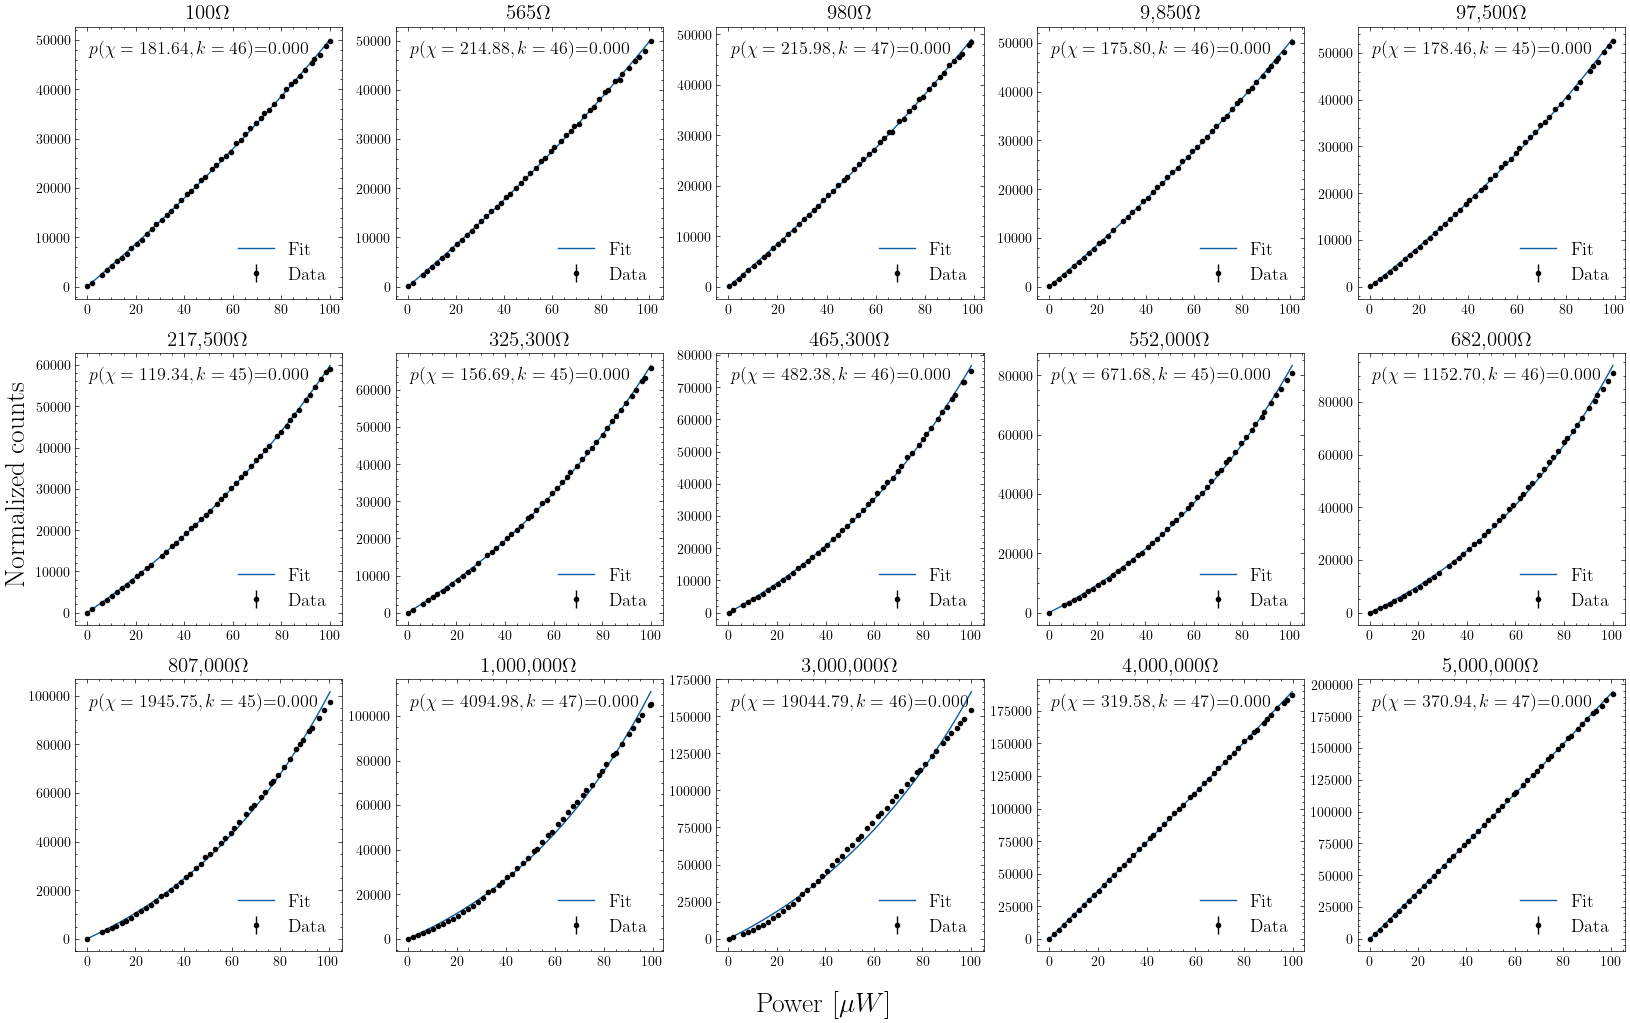

In [11]:
plot_all_activation_fits(fit_inputs_softmax, fit_results_softmax, resistances, outliers)

In [12]:
fit_inputs_softplus = FitInput.build_fitinputs(
    powers,
    counts / np.max(counts, axis=1).reshape(-1, 1),
    np.sqrt(counts) / np.max(counts, axis=1).reshape(-1, 1),
    softplus_fit,
    [0.013376581574336244, -34.558878202081395, -0.9503111307571402],
)
fit_results_softplus = all_activation_fits(fit_inputs_softplus, outliers)

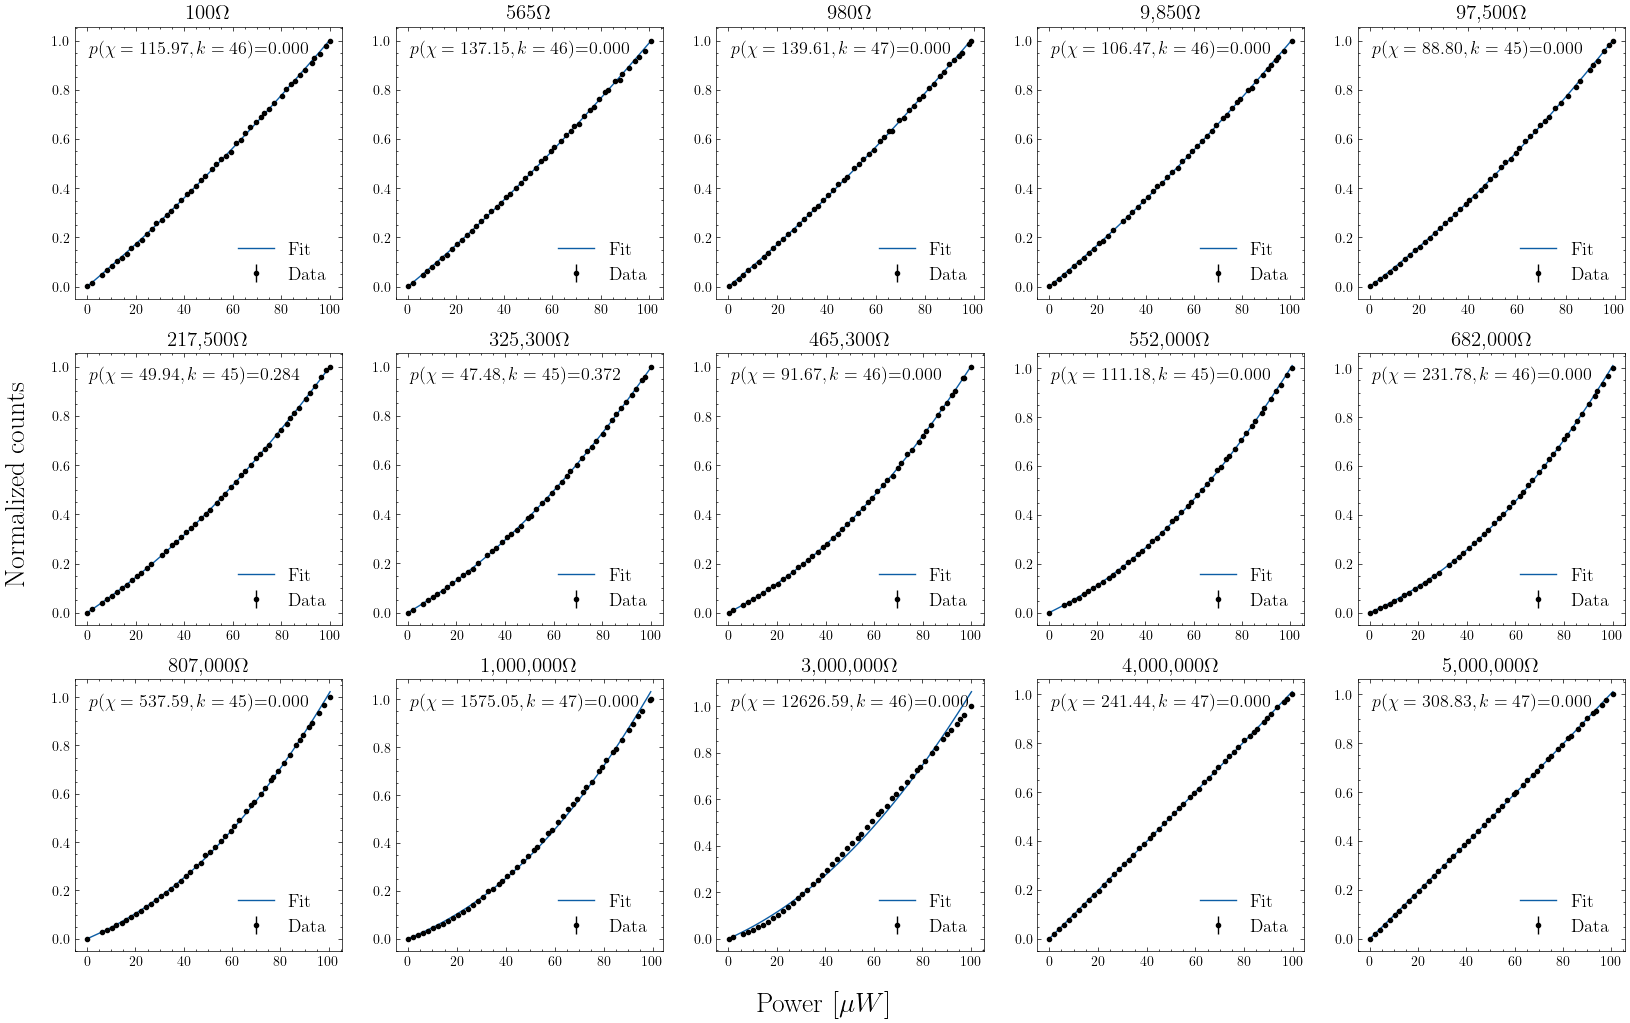

In [13]:
plot_all_activation_fits(fit_inputs_softplus, fit_results_softplus, resistances, outliers)

In [14]:
fit_inputs_softplus2 = FitInput.build_fitinputs(
    powers,
    counts / np.max(counts, axis=1).reshape(-1, 1),
    np.sqrt(counts) / np.max(counts, axis=1).reshape(-1, 1),
    softplus2_fit,
    [0.007623752874988477, 17.106441164576736, 0.009212822999053238, -1.3775013816219899],
)
fit_results_softplus2 = all_activation_fits(fit_inputs_softplus2, outliers)

NOTE: fit 0 was not completely successful
NOTE: fit 1 was not completely successful
NOTE: fit 2 was not completely successful
NOTE: fit 3 was not completely successful
NOTE: fit 4 was not completely successful
NOTE: fit 5 was not completely successful
NOTE: fit 6 was not completely successful
NOTE: fit 7 was not completely successful
NOTE: fit 8 was not completely successful
NOTE: fit 9 was not completely successful
NOTE: fit 10 was not completely successful
NOTE: fit 11 was not completely successful
NOTE: fit 13 was not completely successful
NOTE: fit 14 was not completely successful


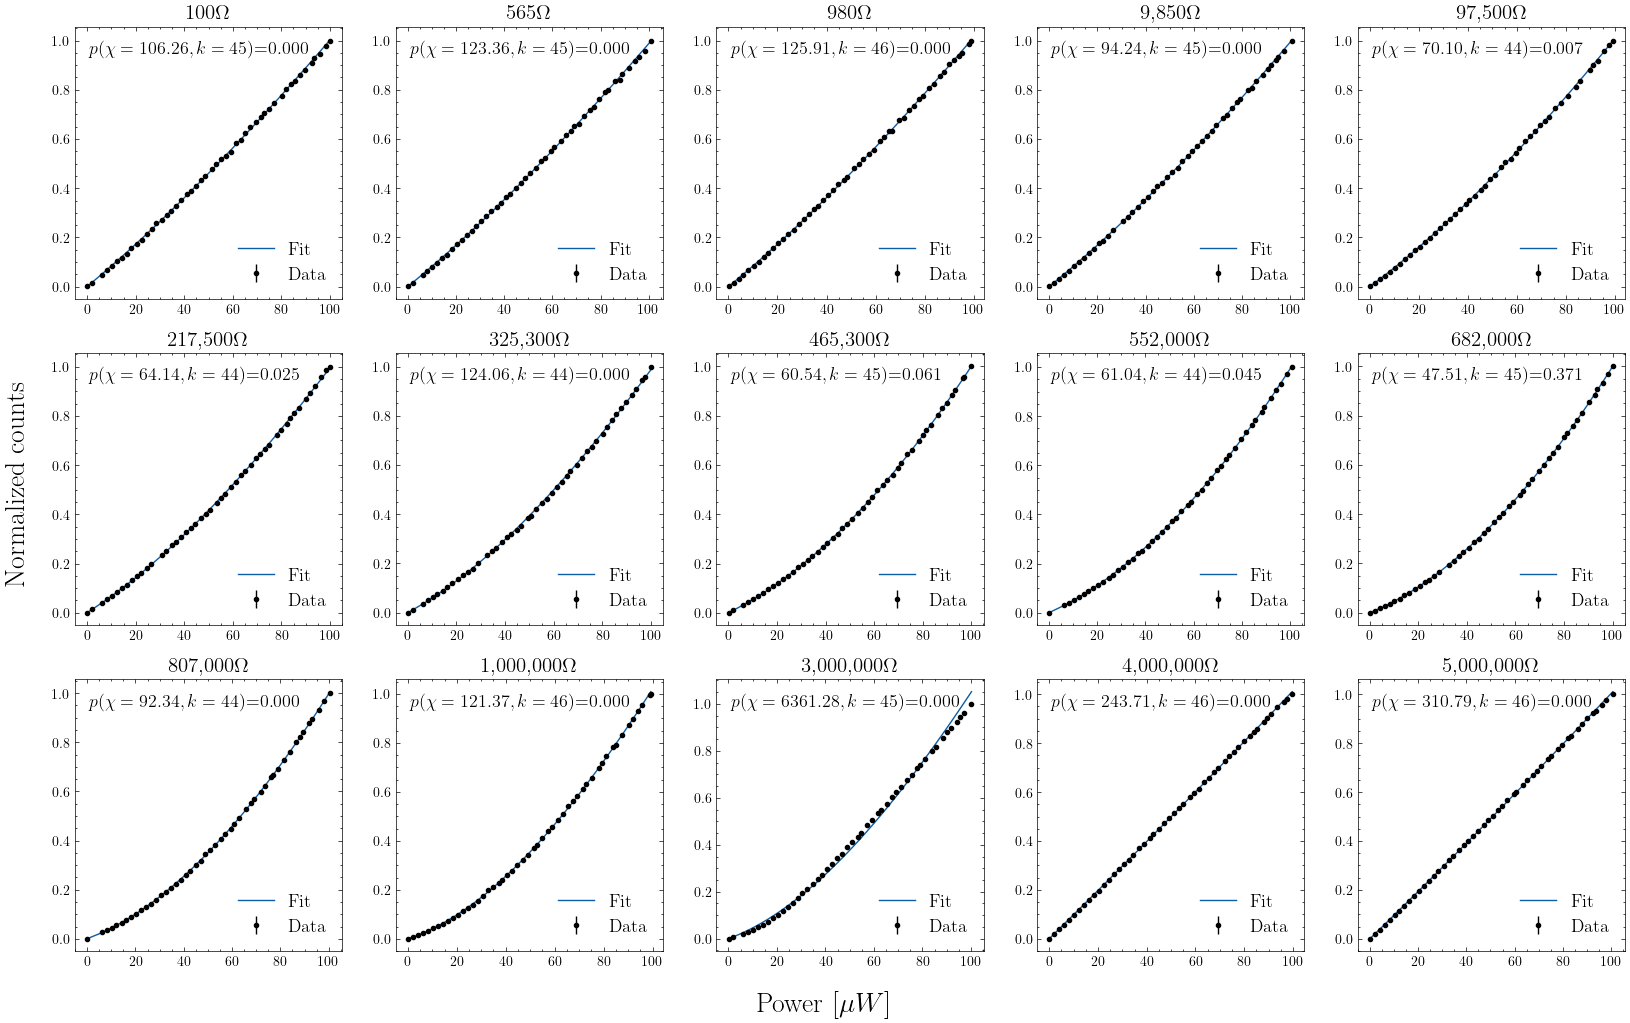

In [15]:
plot_all_activation_fits(fit_inputs_softplus2, fit_results_softplus2, resistances, outliers)

In [16]:
fit_inputs_leaky_softplus1 = FitInput.build_fitinputs(
    powers,
    counts / np.max(counts, axis=1).reshape(-1, 1),
    np.sqrt(counts) / np.max(counts, axis=1).reshape(-1, 1),
    lsoftplus_fit1,
    [-0.019859928900490962,0.030275475343129358,-70.51646487861862,-2.2907015778579267],
)
fit_results_leaky_softplus1 = all_activation_fits(fit_inputs_leaky_softplus1, outliers)

NOTE: fit 0 was not completely successful
NOTE: fit 2 was not completely successful
NOTE: fit 13 was not completely successful
NOTE: fit 14 was not completely successful


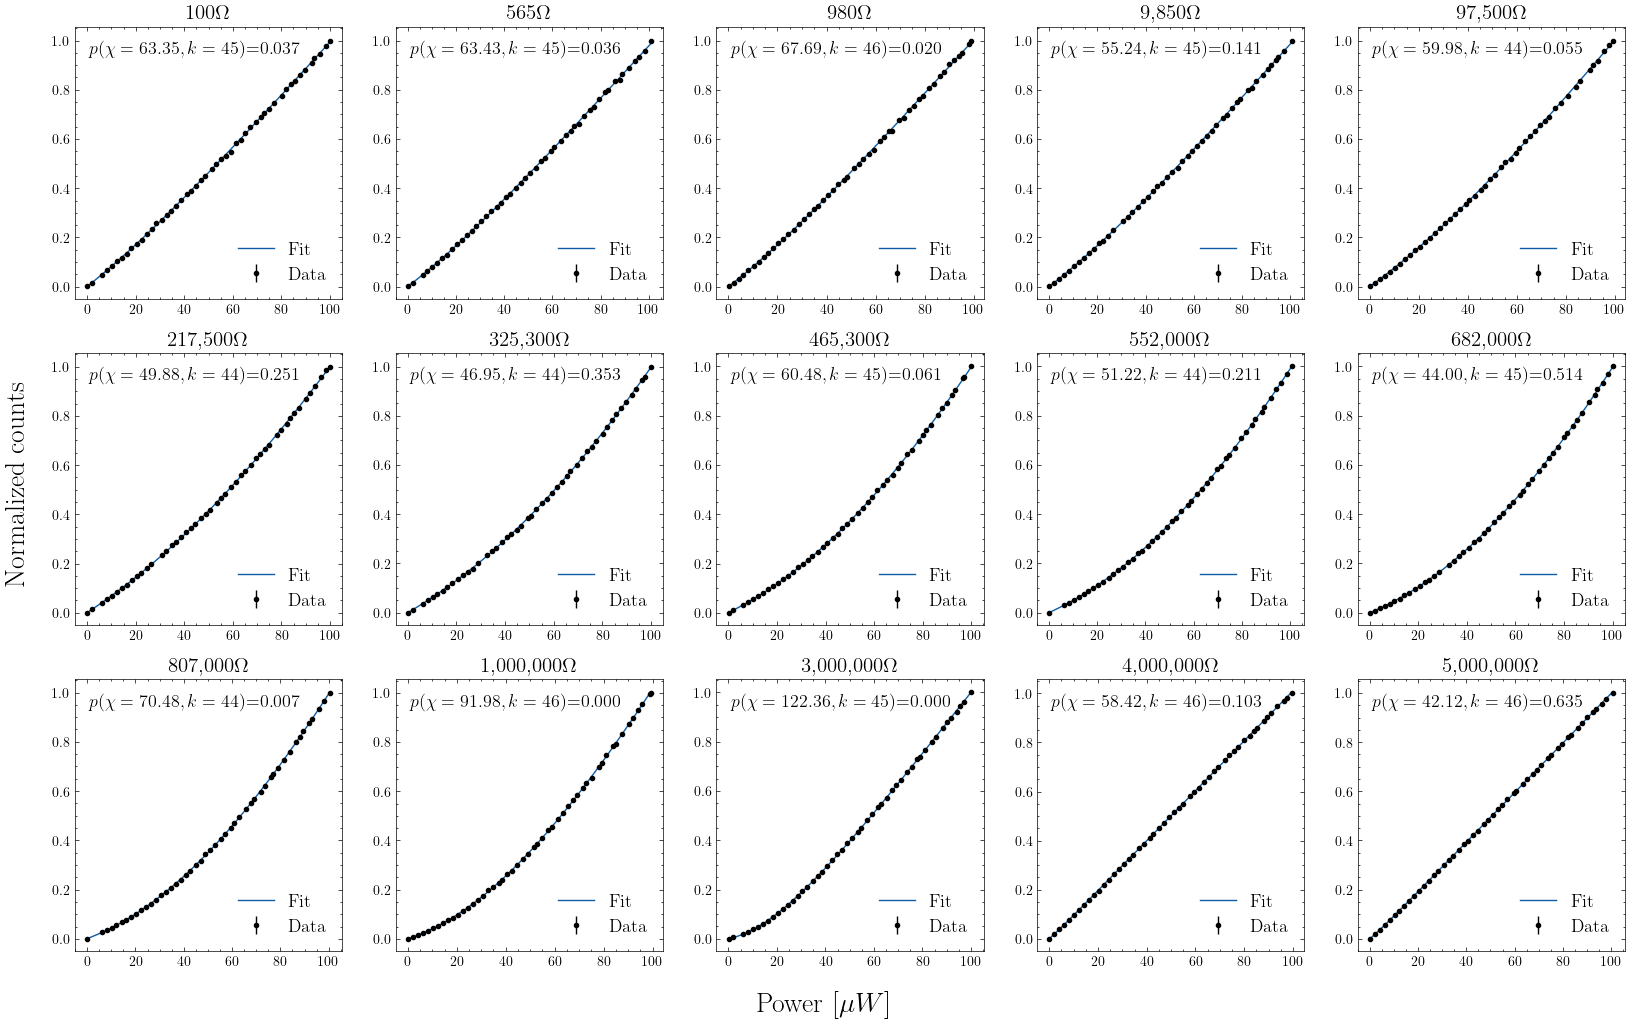

In [17]:
plot_all_activation_fits(fit_inputs_leaky_softplus1, fit_results_leaky_softplus1, resistances, outliers)

In [18]:
fit_inputs_leaky_softplus2 = FitInput.build_fitinputs(
    powers,
    counts / np.max(counts, axis=1).reshape(-1, 1),
    np.sqrt(counts) / np.max(counts, axis=1).reshape(-1, 1),
    lsoftplus_fit2,
    [0.002145224285185682,0.03852182774554627,-15.680176182593234,0.22712850845474875,-0.23563589640451332],
)
fit_results_leaky_softplus2 = all_activation_fits(fit_inputs_leaky_softplus2, outliers, 100)

NOTE: fit 0 was not completely successful
NOTE: fit 1 was not completely successful
NOTE: fit 2 was not completely successful
NOTE: fit 3 was not completely successful
NOTE: fit 4 was not completely successful
NOTE: fit 5 was not completely successful
NOTE: fit 6 was not completely successful
NOTE: fit 7 was not completely successful
NOTE: fit 8 was not completely successful
NOTE: fit 9 was not completely successful
NOTE: fit 10 was not completely successful
NOTE: fit 11 was not completely successful
NOTE: fit 12 was not completely successful
NOTE: fit 13 was not completely successful
NOTE: fit 14 was not completely successful


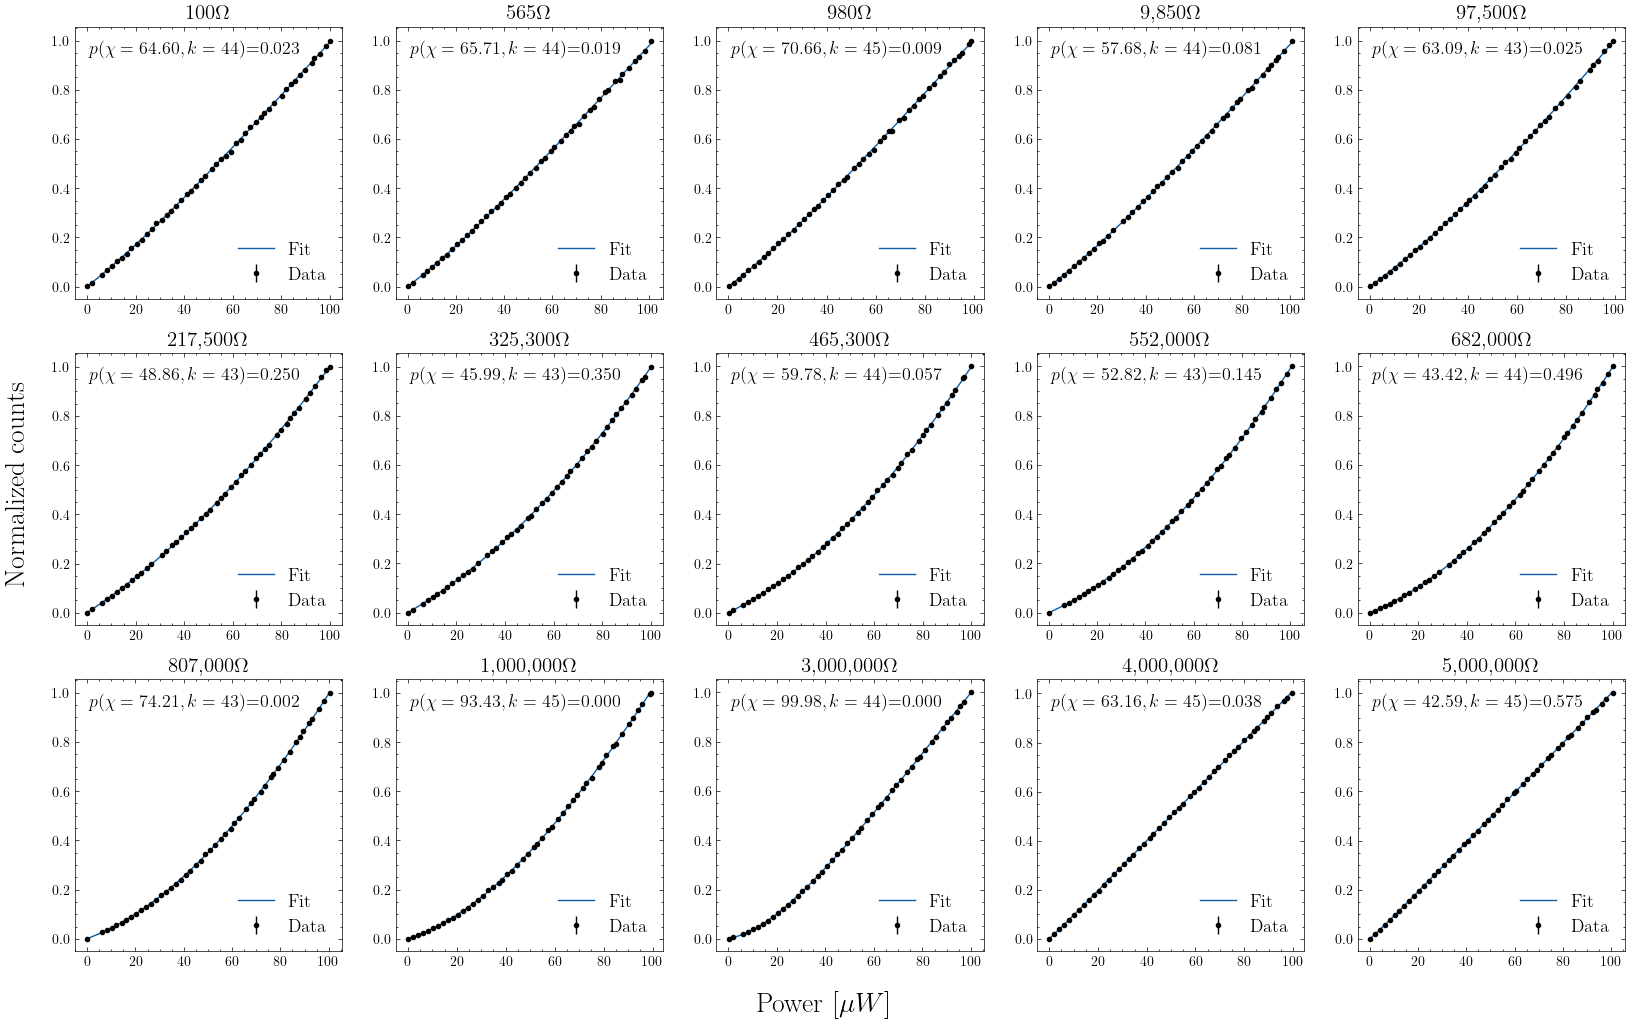

In [19]:
plot_all_activation_fits(fit_inputs_leaky_softplus2, fit_results_leaky_softplus2, resistances, outliers)

In [20]:
fit_inputs_smu1 = FitInput.build_fitinputs(
    powers,
    counts / np.max(counts, axis=1).reshape(-1, 1),
    np.sqrt(counts) / np.max(counts, axis=1).reshape(-1, 1),
    smu_fit1,
    [3.7748236625197054, 208.45304260948782, 0.0012554610163101282, 0.0],
)
fit_results_smu1 = all_activation_fits(fit_inputs_smu1, outliers, opt_rounds=100)

NOTE: fit 0 was not completely successful
NOTE: fit 1 was not completely successful
NOTE: fit 2 was not completely successful
NOTE: fit 3 was not completely successful
NOTE: fit 4 was not completely successful
NOTE: fit 5 was not completely successful
NOTE: fit 6 was not completely successful
NOTE: fit 7 was not completely successful
NOTE: fit 8 was not completely successful
NOTE: fit 9 was not completely successful
NOTE: fit 10 was not completely successful
NOTE: fit 11 was not completely successful
NOTE: fit 12 was not completely successful
NOTE: fit 13 was not completely successful
NOTE: fit 14 was not completely successful


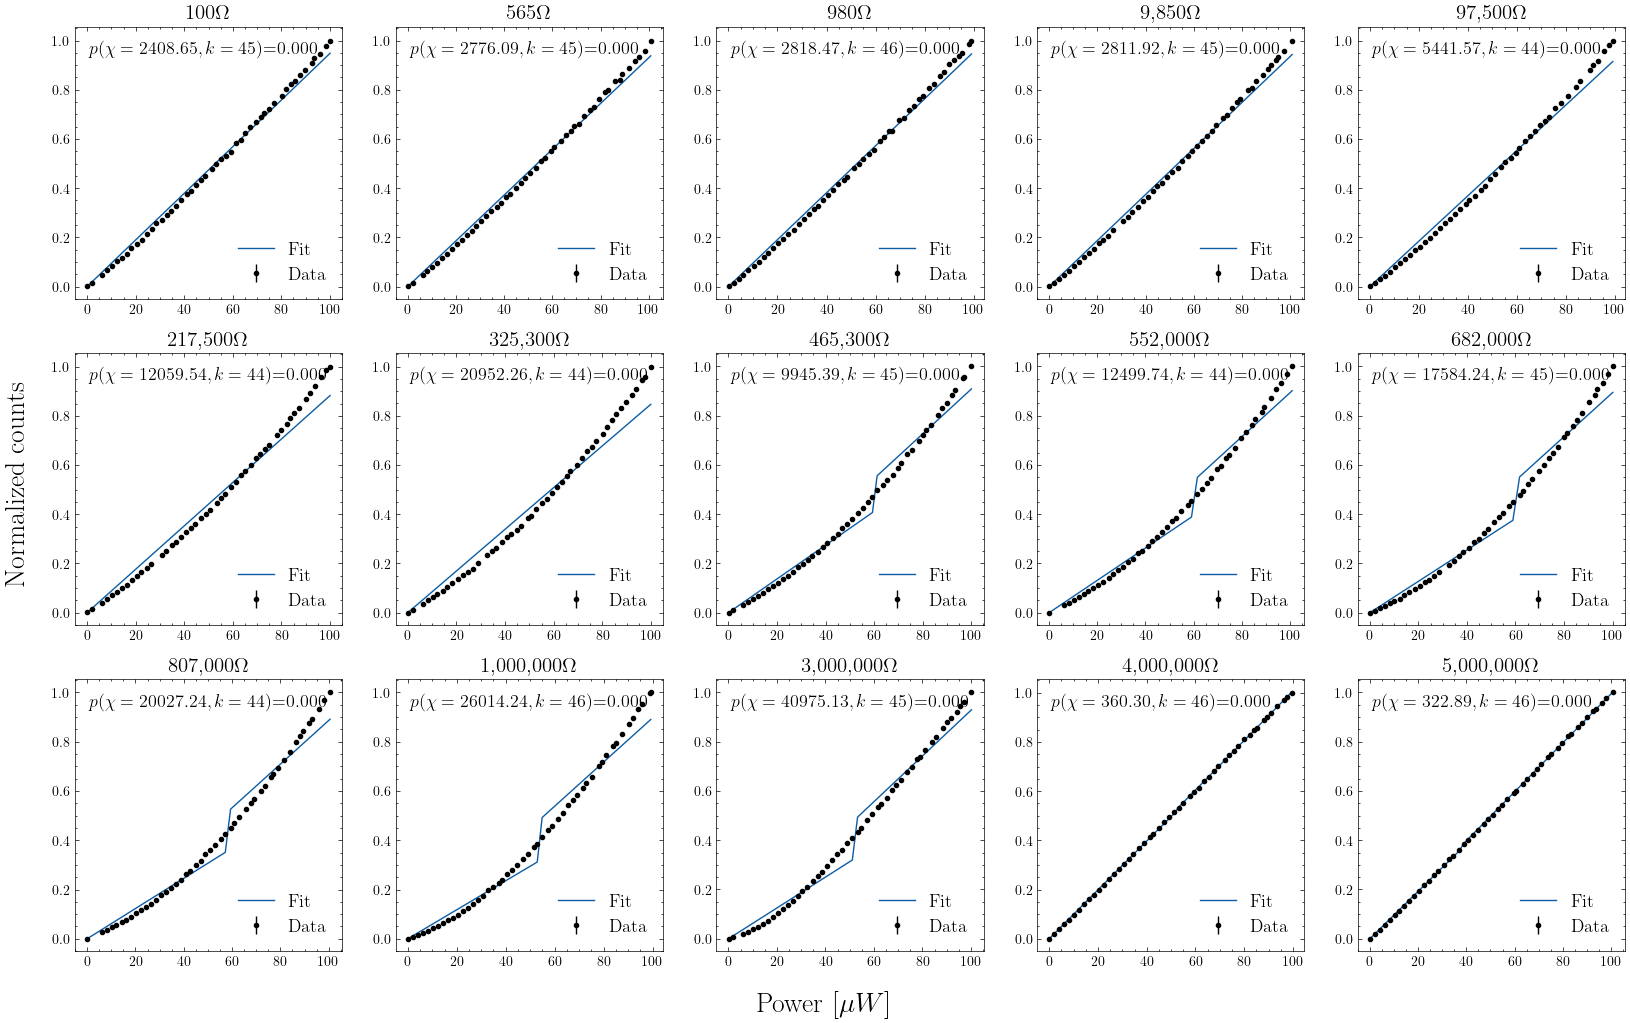

In [21]:
plot_all_activation_fits(fit_inputs_smu1, fit_results_smu1, resistances, outliers)

In [9]:
wl = 2.99792458e5 / 321.5  # Frequency in Thz to wavelength in nm
fit_inputs_fk = FitInput.build_from_fk_fit(powers, counts, np.sqrt(counts), [0.02, -300, 1000], resistances * 1e-6, 3.5e-3, wl, 0.3, 298, -4)
fit_outputs_fk = all_activation_fits(fit_inputs_fk, outliers, opt_rounds=10, softloss=True)

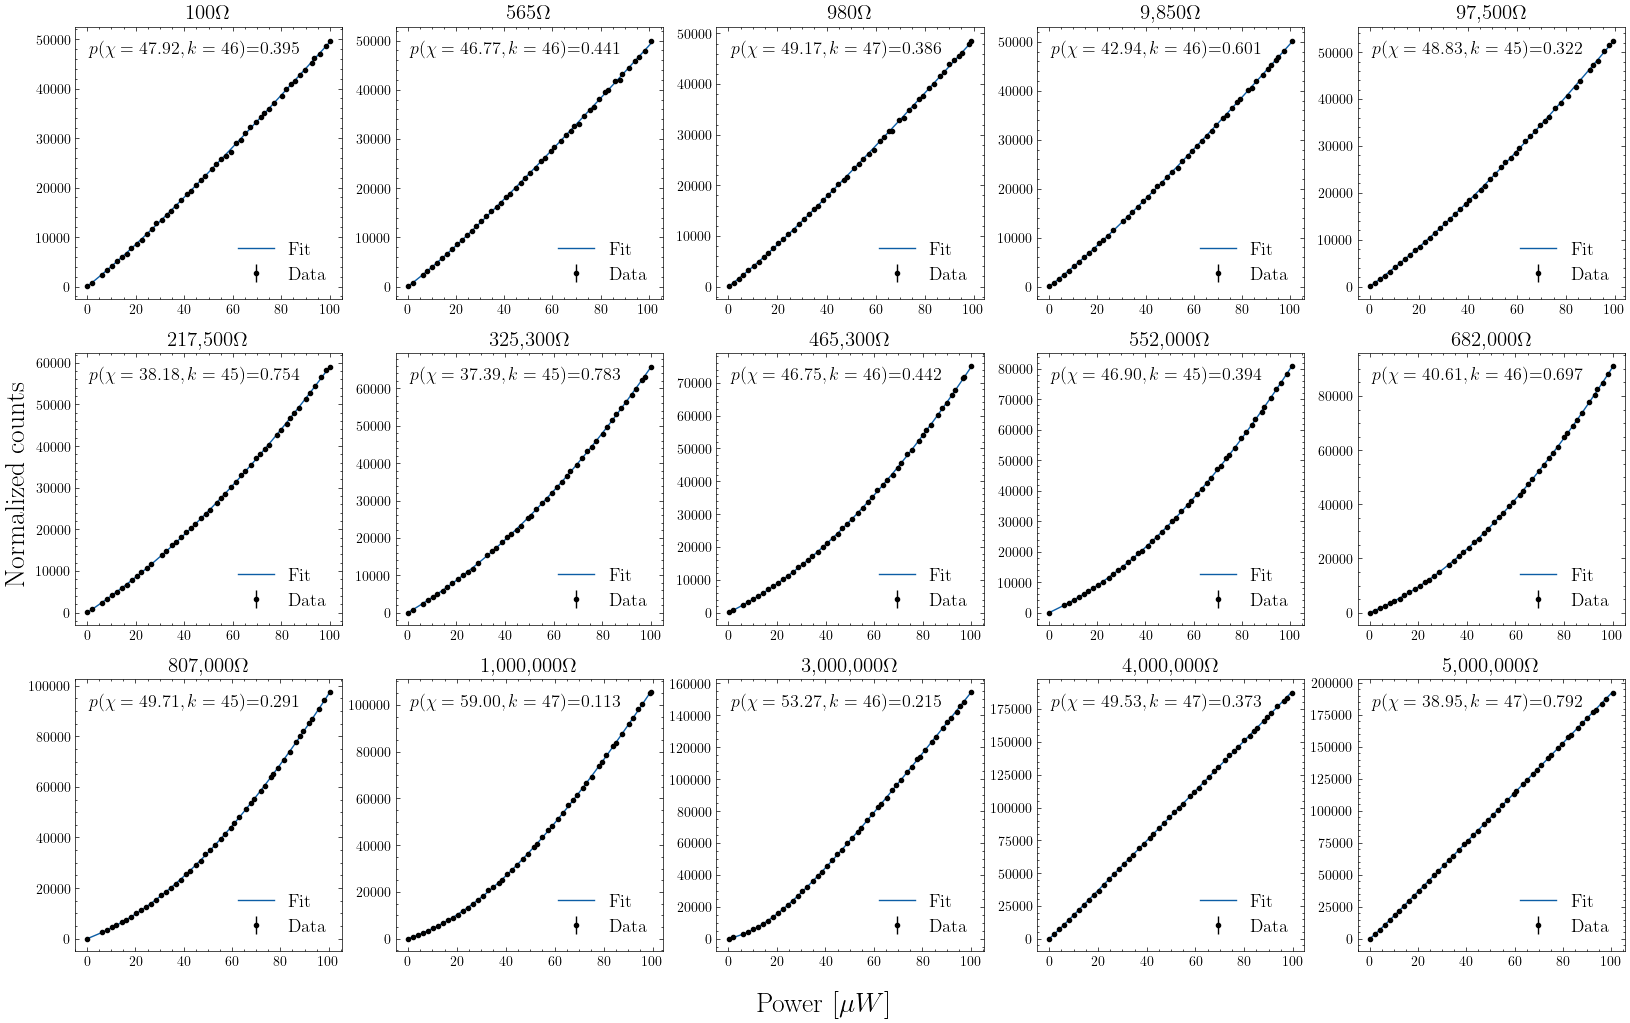

In [10]:
plot_all_activation_fits(fit_inputs_fk, fit_outputs_fk, resistances, outliers)

In [11]:
fit_outputs_fk

[FitResult(parameters=[211.953025278228, -854.1135639117952, 571.161971283523], parameter_errors=[36.142344385170894, 3.977827403567205, 12.457331338870375], chi2=47.91653208466656, ndof=46, p_value=0.3949494901949162, success=True),
 FitResult(parameters=[45.454713981842175, -847.2281369184484, 559.7260881073837], parameter_errors=[7.822172863698132, 3.4184754419357373, 11.071560732553738], chi2=46.76751148305575, ndof=46, p_value=0.4407538472956394, success=True),
 FitResult(parameters=[26.336711102701774, -847.6422617407462, 557.5854990392012], parameter_errors=[4.326975401266161, 3.229254013869499, 10.53036245136085], chi2=49.17423389710332, ndof=47, p_value=0.3861155364980947, success=True),
 FitResult(parameters=[1.9647421191465675, -841.1249988544107, 589.4795265610015], parameter_errors=[0.3304099565041014, 4.7075894750073175, 14.966415393486395], chi2=42.9371606756579, ndof=46, p_value=0.6013067921871802, success=True),
 FitResult(parameters=[0.13238215286548297, -771.66803084

In [25]:
linspace = np.linspace(powerlist[0], powerlist[-1], 1100)
derivs = []
max_derivs = []
max_nl_power = []
max_derivs_2 = []
for idx, fit_output in enumerate(fit_outputs_fk[:-2]):
    fit_func = fit_inputs_fk[idx].fit_func
    deriv = np.gradient(np.gradient(fit_func(linspace, *fit_output.parameters), linspace,edge_order=2), linspace,edge_order=2)
    norm_factor = np.mean(np.gradient(fit_func(linspace, *fit_output.parameters), linspace,edge_order=2)[-100:])
    derivs.append(deriv)
    max_derivs.append(np.max(deriv))
    max_derivs_2.append(np.max(deriv) / norm_factor)
    max_nl_power.append(linspace[np.argmax(deriv)])
derivs = np.array(derivs)
max_derivs = np.array(max_derivs) / np.max(max_derivs)

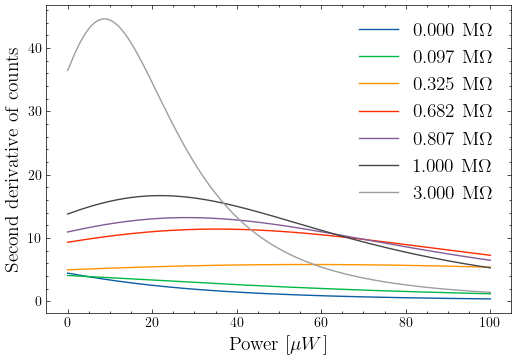

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in [0, 4, 6, 9, 10, 11, 12]:
    ax.plot(linspace, derivs[i], label=fr"{resistances[i] * 1e-6:.3f} M$\Omega$")

ax.set_xlabel(r"Power [$\mu W$]", fontsize=14)
ax.set_ylabel("Second derivative of counts", fontsize=14)
plt.legend(fontsize=14, frameon=False)
# savefig(NB_NAME, "second_derivs", fig)

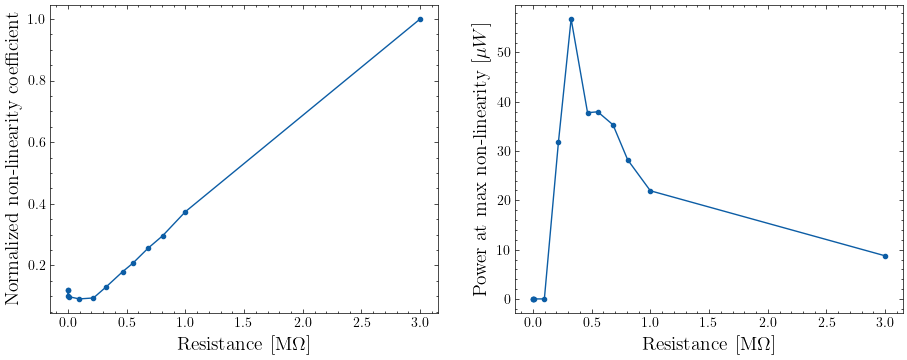

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.set_xlabel(r"Resistance [M$\Omega$]", fontsize=14)
ax1.set_ylabel("Normalized non-linearity coefficient", fontsize=14)
ax1.plot(resistances[:-2] * 1e-6, max_derivs, '.-')

ax2.set_xlabel(r"Resistance [M$\Omega$]", fontsize=14)
ax2.set_ylabel("Power at max non-linearity [$\mu W$]", fontsize=14)
ax2.plot(resistances[:-2] * 1e-6, max_nl_power, '.-')
# savefig(NB_NAME, "nl_coeffs", fig)

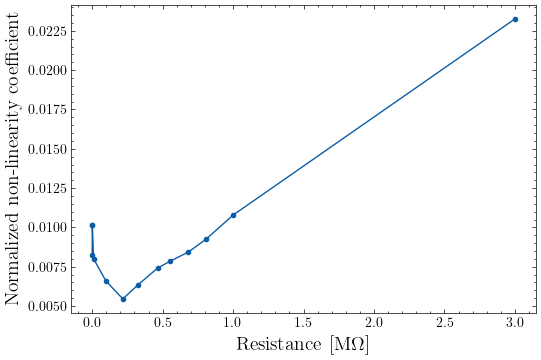

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel(r"Resistance [M$\Omega$]", fontsize=14)
ax.set_ylabel("Normalized non-linearity coefficient", fontsize=14)
ax.plot(resistances[:-2] * 1e-6, max_derivs_2, '.-')

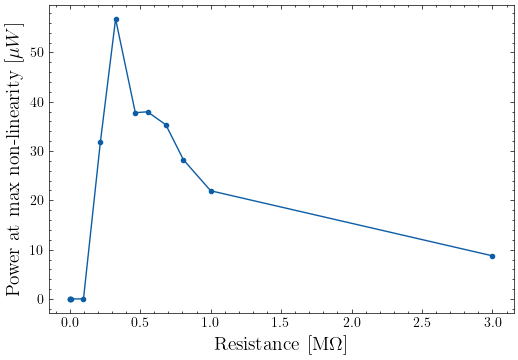

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel(r"Resistance [M$\Omega$]", fontsize=14)
ax.set_ylabel("Power at max non-linearity [$\mu W$]", fontsize=14)
ax.plot(resistances[:-2] * 1e-6, max_nl_power, '.-')

In [28]:
resistances_lin = np.linspace(0.1, 10, 100)
derivs_max_sim = []
for idx, resistance in enumerate(resistances_lin):
    if idx % 10 == 0:
        print(idx)
    fk_fit = FKFit(linspace, resistance, 3.5e-3, wl, 0.3, 298, -4)
    y_fit = fk_fit.FK_fit_power_scaled(linspace, 0.02, -400)
    deriv = np.gradient(np.gradient(y_fit, linspace, edge_order=2), linspace, edge_order=2)
    derivs_max_sim.append(np.max(deriv))
derivs_max_sim = np.array(derivs_max_sim)

0
10
20
30
40
50
60
70
80
90


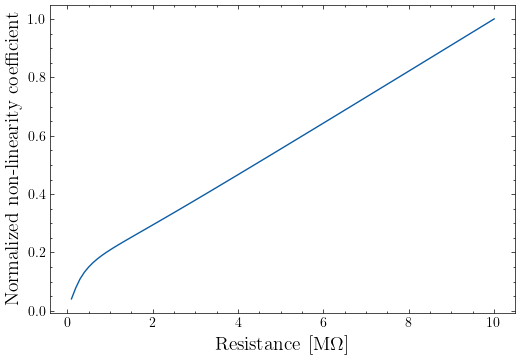

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel(r"Resistance [M$\Omega$]", fontsize=14)
ax.set_ylabel("Normalized non-linearity coefficient", fontsize=14)
ax.plot(resistances_lin, derivs_max_sim / np.max(derivs_max_sim))